### Load the dataset

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

#now load this dataset 
h5f = h5py.File('scatter8.h5','r')
Y = h5f['sizes'][:]
X = h5f['spectrum'][:]

#create a train validate test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


# parameters of the dataset, this information is provided to us
num_shells = Y.shape[1]
num_lpoints = X.shape[1]
lam_min = 300
lam_max = 1200
size_min = 30
size_max = 70
size_av = 0.5*(size_max + size_min)
lams = np.linspace(lam_min, lam_max, num_lpoints)



#normalize the data right here
x_train = (x_train - np.mean(x_train))/(np.amax(x_train) - np.mean(x_train))
x_test = (x_test - np.mean(x_train))/(np.amax(x_train) - np.mean(x_train))

y_train = 2*(y_train - size_av) /(size_max - size_min)
y_test = 2*(y_test - size_av) /(size_max - size_min)

x_train[11]
y_train[11]

Dataset has been loaded
x-train (60000, 250)
x-test  (40000, 250)
y-train (60000, 8)
y-test  (40000, 8)


array([-0.25, -0.1 ,  0.35, -0.45,  0.95, -0.2 ,  0.7 ,  0.7 ])

### Develop the models

In [18]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = 100*np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return np.mean(y_err)

def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(num_shells, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(num_lpoints, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(num_shells, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam')
    #model.compile(loss='mean_squared_error', optimizer='adam')
    return model



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 250)               62750     
_________________________________________________________________
second (Dense)               (None, 250)               62750     
_________________________________________________________________
third (Dense)                (None, 250)               62750     
_________________________________________________________________
fourth (Dense)               (None, 250)               62750     
_________________________________________________________________
last (Dense)                 (None, 8)                 2008      
Total params: 253,008
Trainable params: 253,008
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/500
 3904/48000 [=>............................] - ETA: 2s - loss: 98.8402 

/home/hegder/anaconda3/envs/deep/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 2s 44us/step - loss: 75.8952 - val_loss: 65.2046
Epoch 2/500
48000/48000 [==============================] - 2s 44us/step - loss: 63.7434 - val_loss: 61.6133
Epoch 3/500
48000/48000 [==============================] - 2s 43us/step - loss: 57.9065 - val_loss: 57.0714
Epoch 4/500
48000/48000 [==============================] - 2s 44us/step - loss: 53.3616 - val_loss: 50.6625
Epoch 5/500
48000/48000 [==============================] - 2s 43us/step - loss: 51.6452 - val_loss: 50.2306
Epoch 6/500
48000/48000 [==============================] - 2s 43us/step - loss: 49.4095 - val_loss: 49.1430
Epoch 7/500
48000/48000 [==============================] - 2s 44us/step - loss: 48.4011 - val_loss: 46.9209
Epoch 8/500
48000/48000 [==============================] - 2s 41us/step - loss: 47.6297 - val_loss: 47.5393
Epoch 9/500
48000/48000 [==============================] - 2s 44us/step - loss: 46.3921 - val_loss: 49.4749
Epoch 10/500
48000/48000 [==============

48000/48000 [==============================] - 2s 44us/step - loss: 31.1564 - val_loss: 35.2143
Epoch 77/500
48000/48000 [==============================] - 2s 42us/step - loss: 30.9474 - val_loss: 34.2457
Epoch 78/500
48000/48000 [==============================] - 2s 45us/step - loss: 31.0316 - val_loss: 34.2371
Epoch 79/500
48000/48000 [==============================] - 2s 43us/step - loss: 30.7783 - val_loss: 33.6840
Epoch 80/500
48000/48000 [==============================] - 2s 44us/step - loss: 30.9667 - val_loss: 34.0689
Epoch 81/500
48000/48000 [==============================] - 2s 41us/step - loss: 30.5627 - val_loss: 34.2137
Epoch 82/500
48000/48000 [==============================] - 2s 43us/step - loss: 30.5999 - val_loss: 32.5479
Epoch 83/500
48000/48000 [==============================] - 2s 44us/step - loss: 30.3664 - val_loss: 36.8031
Epoch 84/500
48000/48000 [==============================] - 2s 42us/step - loss: 30.6851 - val_loss: 33.9655
Epoch 85/500
48000/48000 [======

Epoch 151/500
48000/48000 [==============================] - 2s 41us/step - loss: 26.8144 - val_loss: 32.6129
Epoch 152/500
48000/48000 [==============================] - 2s 43us/step - loss: 26.9214 - val_loss: 33.6837
Epoch 153/500
48000/48000 [==============================] - 2s 41us/step - loss: 26.8884 - val_loss: 33.7972
Epoch 154/500
48000/48000 [==============================] - 2s 44us/step - loss: 27.0753 - val_loss: 32.8763
Epoch 155/500
48000/48000 [==============================] - 2s 41us/step - loss: 26.8999 - val_loss: 34.6852
Epoch 156/500
48000/48000 [==============================] - 2s 43us/step - loss: 26.7595 - val_loss: 35.1987
Epoch 157/500
48000/48000 [==============================] - 2s 44us/step - loss: 26.8332 - val_loss: 34.0375
Epoch 158/500
48000/48000 [==============================] - 2s 42us/step - loss: 26.7633 - val_loss: 32.5161
Epoch 159/500
48000/48000 [==============================] - 2s 45us/step - loss: 26.8590 - val_loss: 34.6899
Epoch 160/

48000/48000 [==============================] - 2s 44us/step - loss: 24.7763 - val_loss: 33.5500
Epoch 226/500
48000/48000 [==============================] - 2s 40us/step - loss: 24.7552 - val_loss: 33.6286
Epoch 227/500
48000/48000 [==============================] - 2s 43us/step - loss: 24.8854 - val_loss: 32.4195
Epoch 228/500
48000/48000 [==============================] - 2s 40us/step - loss: 24.8242 - val_loss: 33.0474
Epoch 229/500
48000/48000 [==============================] - 2s 44us/step - loss: 24.8158 - val_loss: 32.1110
Epoch 230/500
48000/48000 [==============================] - 2s 42us/step - loss: 24.6397 - val_loss: 32.3943
Epoch 231/500
48000/48000 [==============================] - 2s 44us/step - loss: 24.6855 - val_loss: 32.4738
Epoch 232/500
48000/48000 [==============================] - 2s 41us/step - loss: 24.8916 - val_loss: 32.4745
Epoch 233/500
48000/48000 [==============================] - 2s 43us/step - loss: 24.6760 - val_loss: 32.7121
Epoch 234/500
48000/4800

48000/48000 [==============================] - 2s 41us/step - loss: 23.6717 - val_loss: 32.7561
Epoch 300/500
48000/48000 [==============================] - 2s 45us/step - loss: 23.4224 - val_loss: 33.2430
Epoch 301/500
48000/48000 [==============================] - 2s 42us/step - loss: 23.3851 - val_loss: 32.5215
Epoch 302/500
48000/48000 [==============================] - 2s 44us/step - loss: 23.3766 - val_loss: 33.4546
Epoch 303/500
48000/48000 [==============================] - 2s 44us/step - loss: 23.4190 - val_loss: 33.2054
Epoch 304/500
48000/48000 [==============================] - 2s 44us/step - loss: 23.4672 - val_loss: 34.3987
Epoch 305/500
48000/48000 [==============================] - 2s 44us/step - loss: 23.5041 - val_loss: 32.6472
Epoch 306/500
48000/48000 [==============================] - 2s 43us/step - loss: 23.3091 - val_loss: 32.5146
Epoch 307/500
48000/48000 [==============================] - 2s 44us/step - loss: 23.4155 - val_loss: 32.3050
Epoch 308/500
48000/4800

48000/48000 [==============================] - 2s 42us/step - loss: 22.6816 - val_loss: 32.6554
Epoch 374/500
48000/48000 [==============================] - 2s 44us/step - loss: 22.8329 - val_loss: 33.9426
Epoch 375/500
48000/48000 [==============================] - 2s 42us/step - loss: 22.5798 - val_loss: 32.8517
Epoch 376/500
48000/48000 [==============================] - 2s 43us/step - loss: 22.7706 - val_loss: 33.1280
Epoch 377/500
48000/48000 [==============================] - 2s 44us/step - loss: 22.4024 - val_loss: 33.0839
Epoch 378/500
48000/48000 [==============================] - 2s 42us/step - loss: 22.7087 - val_loss: 33.3125
Epoch 379/500
48000/48000 [==============================] - 2s 45us/step - loss: 22.4817 - val_loss: 33.5527
Epoch 380/500
48000/48000 [==============================] - 2s 42us/step - loss: 22.6828 - val_loss: 33.0956
Epoch 381/500
48000/48000 [==============================] - 2s 44us/step - loss: 22.7045 - val_loss: 32.5384
Epoch 382/500
48000/4800

48000/48000 [==============================] - 2s 44us/step - loss: 21.8280 - val_loss: 32.3705
Epoch 448/500
48000/48000 [==============================] - 2s 42us/step - loss: 21.8054 - val_loss: 33.4401
Epoch 449/500
48000/48000 [==============================] - 2s 45us/step - loss: 22.0803 - val_loss: 34.2190
Epoch 450/500
48000/48000 [==============================] - 2s 44us/step - loss: 21.8486 - val_loss: 34.3854
Epoch 451/500
48000/48000 [==============================] - 2s 42us/step - loss: 22.0129 - val_loss: 33.1505
Epoch 452/500
48000/48000 [==============================] - 2s 45us/step - loss: 21.9422 - val_loss: 32.5661
Epoch 453/500
48000/48000 [==============================] - 2s 41us/step - loss: 21.9982 - val_loss: 32.1778
Epoch 454/500
48000/48000 [==============================] - 2s 46us/step - loss: 21.9323 - val_loss: 32.9895
Epoch 455/500
48000/48000 [==============================] - 2s 42us/step - loss: 21.9386 - val_loss: 33.4997
Epoch 456/500
48000/4800

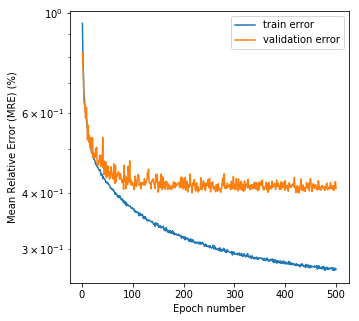

In [19]:
#staging area for new models 
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(32*2.5)
    val_loss = np.asarray(val_loss)/(32*2.5)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='validation error')
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Mean Relative Error (MRE) (%)')
    axs.legend(loc="best")

    
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = naiveploss_model()

#SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()    
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
history = model.fit(x_t, y_t,
                    batch_size=64,
                    epochs=500, 
                    verbose=1,
                    validation_data=(x_v, y_v))
plot_training_history(history)

In [40]:
compa = np.loadtxt('qestsave.txt')
compa = (compa - np.mean(X))/(np.amax(X) - np.mean(X))

shells = model.predict(np.expand_dims(compa, axis = 0))
shells = 0.5*shells*(size_max - size_min) + size_av









array([-0.0839727 , -0.08115825, -0.07789629, -0.07413596, -0.06966534,
       -0.06424338, -0.05846449, -0.05518717, -0.05508052, -0.05003458,
       -0.03712746, -0.02683466, -0.03899915, -0.06264444, -0.04291657,
        0.07685165,  0.23203474,  0.17212413, -0.03108999, -0.14354838,
       -0.00879192, -0.22250668, -0.32736186, -0.39229207, -0.44524914,
       -0.47044995, -0.45767632, -0.41134213, -0.34440424, -0.26765756,
       -0.18125351, -0.05496553,  0.21776205,  0.32161838, -0.02924759,
       -0.16889565, -0.22157882, -0.24315792, -0.24700004, -0.23724051,
       -0.21629482, -0.18636271, -0.14950762, -0.10746276, -0.06112408,
       -0.0107143 ,  0.04448801,  0.10628975,  0.17765122,  0.26280046,
        0.3663146 ,  0.48867677,  0.6145306 ,  0.69810398,  0.68617148,
        0.5886505 ,  0.47075481,  0.37685458,  0.31514771,  0.27923319,
        0.26125697,  0.25535975,  0.25765234,  0.26562028,  0.27761229,
        0.29252979,  0.30960144,  0.32828819,  0.34820144,  0.36